In [119]:
using CSV, DataFrames, MarketData, Plots, Statistics, TimeSeries

In [ ]:
c1 = theme_palette(:auto).colors.colors[1]
c2 = theme_palette(:auto).colors.colors[2]
c3 = theme_palette(:auto).colors.colors[3]

In [186]:
function plot_Rclose(ticker::String)
    df = CSV.read("data/" * ticker * ".csv", DataFrame)
    plot(Date.(SubString.(df.Date, 1, 10)), df.Close, label=ticker * " Close", ylabel="EOD Price")
    plot!(Date.(SubString.(df.Date, 1, 10)), df.RClose, color=c2, label="Add back dividend")
end

plot_Rclose (generic function with 1 method)

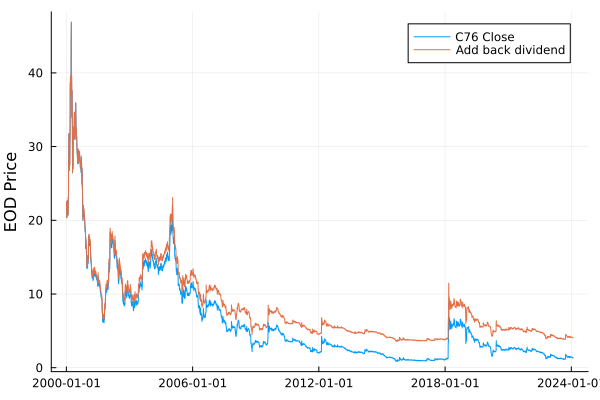

In [194]:
plot_Rclose("C76")

In [ ]:
sti = last(CSV.read("sti_data.csv", DataFrame), 4033)
es3 = CSV.read("data/ES3.csv", DataFrame)

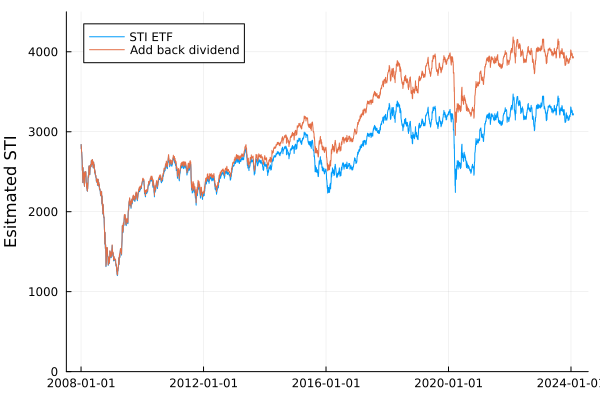

In [181]:
plot(Date.(SubString.(es3.Date, 1, 10)), es3.Close .* 1000, label="STI ETF", ylim=(0, 4500), ylabel="Esitmated STI")
plot!(Date.(SubString.(es3.Date, 1, 10)), es3.RClose .* 1000, color=c2, label="Add back dividend")
# savefig("dividend/sti_estimate.png")

In [7]:
df = CSV.read("data/D8DU.csv", DataFrame)

Row,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,RClose
,String31,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,2007-11-30 00:00:00+08:00,0.179292,0.180738,0.167725,0.179292,1536000,0.0,0.0,0.179292
2,2007-12-03 00:00:00+08:00,0.179292,0.179292,0.179292,0.179292,854000,0.0,0.0,0.180004
3,2007-12-04 00:00:00+08:00,0.179292,0.179292,0.1764,0.1764,1048000,0.0,0.0,0.177824
4,2007-12-05 00:00:00+08:00,0.1764,0.1764,0.1764,0.1764,2175000,0.0,0.0,0.178535
5,2007-12-06 00:00:00+08:00,0.1764,0.185076,0.1764,0.182184,1798000,0.0,0.0,0.185031
6,2007-12-07 00:00:00+08:00,0.182184,0.182184,0.182184,0.182184,0,0.0,0.0,0.185743
7,2007-12-10 00:00:00+08:00,0.185076,0.185076,0.182184,0.182184,123000,0.0,0.0,0.186455
8,2007-12-11 00:00:00+08:00,0.18363,0.185076,0.182184,0.185076,816000,0.0,0.0,0.190058
9,2007-12-12 00:00:00+08:00,0.18363,0.18363,0.18363,0.18363,88000,0.0,0.0,0.189324


In [ ]:
df2 = last(df, 3000)

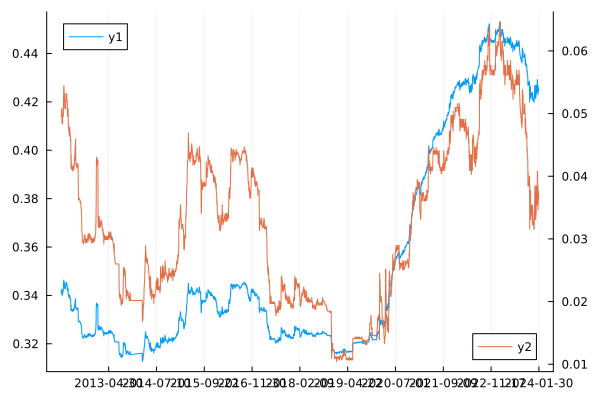

In [24]:
plot(SubString.(df2.Date, 1, 10), df2.RClose)
plot!(twinx(), df2.Close, color=c2)

In [144]:
std(diff(log.(df2.RClose)))

0.0025209873901278603

In [145]:
data = CSV.read("dividend/data.txt", DataFrame)

Row,Year,SG,US,China,Average
,Int64,Float64,Float64,Float64,Float64
1,2023,5.8,2.58,7.13,5.17
2,2022,4.25,2.5,6.42,4.39
3,2021,3.46,1.59,5.9,3.65
4,2020,4.37,2.85,5.64,4.29
5,2019,4.34,2.41,4.8,3.85
6,2018,3.65,2.57,4.75,3.66
7,2017,2.7,1.77,3.23,2.57
8,2016,3.64,1.83,5.32,3.6
9,2015,3.58,1.95,5.41,3.65


In [143]:
plot(data.Year, data.SG, label="SG", ylabel="Dividend(%)", xlabel="Year")
plot!(data.Year, data.China, label="CN")
plot!(data.Year, data.US, label="US")
# scatter!(data.Year, data.Average, label="Average", smooth=true)
savefig("dividend/sg_cn_us.png")

"/Users/wuvist/code/sgx3000/dividend/sg_cn_us.png"

In [87]:
localbanks = CSV.read("dividend/local.csv", DataFrame)

Row,year,ocbc,dbs,uob
,Int64,Float64,Float64,Float64
1,2023,6.15,5.63,5.62
2,2022,4.6,4.25,3.91
3,2021,3.59,3.12,3.68
4,2020,4.3,5.35,3.47
5,2019,4.37,5.8,2.84
6,2018,3.46,4.64,2.85
7,2017,2.91,2.54,2.65
8,2016,4.04,3.46,3.43
9,2015,4.09,3.59,3.06


In [114]:
banks = first(localbanks,21)
plot(banks.year, banks.ocbc, label="OCBC", ylabel="Dividend(%)", xlabel="Year")
plot!(banks.year, banks.dbs, label="DBS")
plot!(banks.year, banks.uob, label="UOB")
savefig("dividend/local.png")

"/Users/wuvist/code/sgx3000/dividend/local.png"